# Tutorial02_metrics: ROC and AUC
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction

In the notebook `tutorial02`, we built a simple **discriminant** $D(x)$ to classify the points $x \in \mathbb{R}^2$ sampled from two known Gaussians. In this notebook we compare the approximate discriminant to the exact one using two measures: the **Receiver Operating Characteristic** (ROC) curve and the **Area Under the (ROC) Curve** (AUC). The exact discriminant is given by 
\begin{align}
    D(x) & = \frac{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)})}{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)}) + \mathcal{N}(x, \mu^{(0)}, \Sigma^{(0)})},
\end{align}
where $\mathcal{N}(x, \mu, \Sigma)$ is the probability density function (pdf) of a bivariate normal.

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
#%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

import joblib
import importlib

import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(DEVICE):4s}')

# file containing parameters of trained model
params_file = 'gauss2d_params.pth' 

Available device: cpu 


## Import exact density

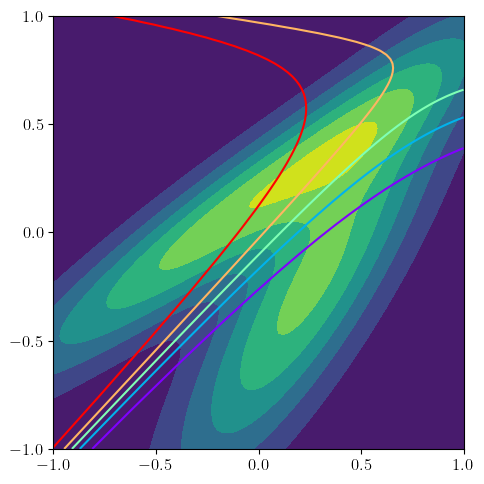

In [3]:
from exactdensity import ExactDensity

fexact = ExactDensity()
fexact.plot()

## Import trained (i.e., fitted) model

In [4]:
import gauss2d
importlib.reload(gauss2d)

model = gauss2d.model
model.load(params_file)

print(model)
print('number of parameters', mlp.number_of_parameters(model))

Gauss2D(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
number of parameters 541


## Load test data

In [5]:
test_data = joblib.load('../data/test_data.pth')

test_loader = dat.DataLoader(test_data, 
                             batch_size=len(test_data))
print(len(test_data))

test_data[:5]

DataLoader
  maxiter:               1
  batch_size:        17000
  shuffle_step:          1

17000


(tensor([[ 0.3696,  0.4530],
         [-0.7306, -1.9174],
         [-0.5869, -0.2649],
         [ 0.7352,  0.0684],
         [ 0.2896,  0.3681]]),
 tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]))

## Compute approximate discriminant values

In [6]:
test_loader.reset()
x, y = next(test_loader)
print('x.shape', x.shape)
print('y.shape', y.shape)

y = y.squeeze()
print('y.shape', y.shape)

Dapprox = model(x).squeeze().detach().cpu().numpy()

print(Dapprox.shape)

x.shape torch.Size([17000, 2])
y.shape torch.Size([17000, 1])
y.shape torch.Size([17000])
(17000,)


## Compute exact discriminant values

In [7]:
fexact = ExactDensity()

x1 = x[:, 0] # extract all rows (:) of column 0
x2 = x[:, 1] # extract all rows (:) of column 1

Dexact = fexact.prob(x1, x2)

print(Dexact.shape)

(17000,)


## Plot distributions of discriminant values
What we are doing here is approximating the 1D densities,

\begin{align}
    p(D | 0) & = \int_{\mathbb{R}^2} \delta(D - f(x, \widehat{\omega})) \, p(x | 0) \, dx, \\
    p(D | 1) & = \int_{\mathbb{R}^2} \delta(D - f(x, \widehat{\omega})) \, p(x | 1) \, dx,
\end{align}

using histograms.

In [8]:
def plot_distribution(D, y, 
                      title=None,
                      nbins=100, 
                      ftsize=FONTSIZE, 
                      fgsize=(5, 3.5)):

    # select "signal" (class with y = 1)
    s = D[y > 0.5]
    
    # select "background" (class with y = 0)
    b = D[y < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)

    if title:
        plt.title(title)
        
    plt.xlim(0, 1)
    plt.xlabel('$D(x)$')
    
    plt.yscale('log')
    plt.ylabel('$p(D|k), k=0, 1$')
    
    plt.hist(b, 
             bins=nbins, 
             color='red',
             alpha=0.3,
             range=(0, 1), 
             density=True, 
             label='background') 
    plt.legend(fontsize='small')
    
    plt.hist(s, 
             bins=nbins, 
             color='blue',
             alpha=0.3,
             range=(0, 1), 
             density=True, 
             label='signal')
    plt.legend(fontsize='small')

    plt.savefig("D_distribution.png")
    plt.show()

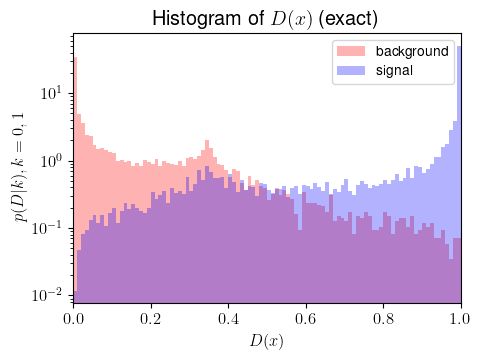

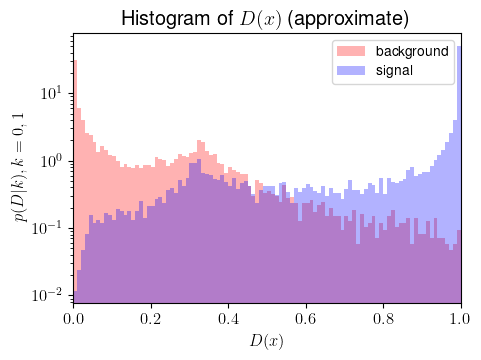

In [9]:
plot_distribution(Dexact, y, 'Histogram of $D(x)$ (exact)')
plot_distribution(Dapprox, y, 'Histogram of $D(x)$ (approximate)')

## Compute ROC and AUC

First compute

\begin{align}
    f_k(D) & = \int_{z=D}^{z=1} p(z | k) \, dz,\quad k = 0, 1,
\end{align}

The ROC curve is $f_1(D) \text{ vs. } f_0(D)$ and the AUC is simply the area beneath it.

In [10]:
# standard measures of model performance
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, D, title=None):
    
    bkg, sig, _ = roc_curve(y, D)
    
    roc_auc = auc(bkg, sig)
    plt.figure(figsize=(3.5, 3.5))

    if title:
        plt.title(title)
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$f_0(D)$', fontsize=12)
    plt.ylabel('$f_1(D)$', fontsize=12)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    
    plt.savefig("ROC.png")
    plt.show()

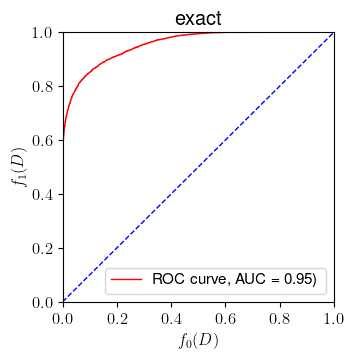

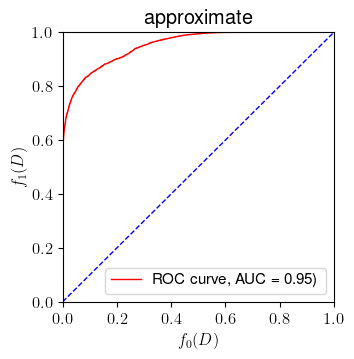

In [11]:
plot_ROC(y, Dexact, 'exact')
plot_ROC(y, Dapprox, 'approximate')